In [20]:
import time
import pandas as pd
import re
import os
from selenium import webdriver
from bs4 import BeautifulSoup

def remove_text(text):
    patterns = [r'\[[^\]]*\]', r'\([^)]*\)'] # [] () 안의 텍스트
    combined_pattern = '|'.join(patterns) # 각 패턴을 비트 OR로 결합
    text = re.sub(combined_pattern, '', text) # 패턴을 적용하여 텍스트 처리
    return text.strip()  # 양쪽 공백 제거

def colection_product(driver, product_name, product_price, discount_rate, review_counts, brand_name):
    html = driver.page_source  # 현재 페이지의 HTML 가져오기
    soup = BeautifulSoup(html, 'html.parser') # BeautifulSoup를 사용하여 데이터 추출
    Parent_Elements = soup.find_all("div", class_="category-feed__content__item-wrap col-6 col-lg-4")

    for child_element in Parent_Elements:
        name_element = child_element.find("span", class_="production-item__header__name")
        price_element = child_element.find("span", class_="production-item-price__price")
        rate_element = child_element.find("span", class_="production-item-price__rate")
        review_element = child_element.find("p", class_="production-item-stats production-item-stats--review")
        brand_element = child_element.find("span", class_="production-item__header__brand")
              
        if name_element and price_element and rate_element and review_element and brand_element:
            product_name.append(remove_text(name_element.get_text()).strip())  # 공백 제거 후 제품명 추가
            product_price.append(price_element.get_text())
            discount_rate.append(rate_element.get_text())
            brand_name.append(brand_element.get_text())
                              
            review_text = review_element.get_text()
            review_data = review_text.split('리뷰 ')[1] # "리뷰" 뒤의 숫자만 추출하여 저장
            review_counts.append(review_data)

    # 마지막까지 스크롤을 1/2만큼 내림
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight/2)")
    time.sleep(2) 
    
############################################### main 시작 ######################################################

output_folder = 'data_100'
os.makedirs(output_folder, exist_ok=True) # 폴더 덮어쓰기
driver = webdriver.Chrome()
scroll_count = 7

# 페이지 순회 
for category_id in range(31):
    url = f"https://ohou.se/store/category?category={category_id}&order=review"
    driver.get(url)
    time.sleep(2)  # 페이지가 모두 로드될 때까지 기다림
    
    product_name = [] # 제품명
    product_price = [] # 제품 가격
    discount_rate = [] # 제품 할인률
    review_counts = [] # 제품 리뷰수
    brand_name = [] # 제품의 브랜드
    
    html_title = driver.page_source  # 현재 페이지의 HTML 가져오기
    soup = BeautifulSoup(html_title, 'html.parser') # BeautifulSoup를 사용하여 데이터 추출
    webpage_title = soup.find("a", class_="link")  # 웹페이지 제목 가져오기

    if webpage_title: # 링크가 존재하는 경우
        link_text = webpage_title.text # 링크의 텍스트 값 가져오기
        cleaned_title = re.sub(r'[^\w\s]', '', link_text) # 특수 문자를 공백으로 대체하여 파일명 생성
    else:
        print(f"Category {category_id}: 페이지 없음")
        continue

    for _ in range(scroll_count):
        colection_product(driver, product_name, product_price, discount_rate, review_counts, brand_name)

    # 처음부터 100개의 데이터만 선택
    selected_product_name = product_name[:100]
    selected_product_price = product_price[:100]
    selected_discount_rate = discount_rate[:100]
    selected_review_counts = review_counts[:100]  
    selected_brand_name = brand_name[:100]
    
    # 담긴 데이터가 없다면
    if len(discount_rate) == 0:
        print(f"Category {category_id}: 페이지 없음")
        continue
        
    # 데이터 길이 확인
    print(f'{cleaned_title}: {len(selected_product_name)}')

    final = pd.DataFrame({'제품명': selected_product_name, '할인가': selected_product_price, 
                          '할인률': selected_discount_rate, '리뷰수': selected_review_counts,
                          '브랜드': selected_brand_name})

    filename = os.path.join(output_folder, f'{cleaned_title}.csv') # 파일 경로 설정
    final.to_csv(filename, encoding='utf-8-sig')
    
driver.quit()

가구: 100
패브릭: 100
데코식물: 100
가전디지털: 100
생활용품: 100
주방용품: 100
공구DIY: 100
인테리어시공: 100
반려동물: 100
Category 9: 페이지 없음
Category 10: 페이지 없음
수납정리: 100
Category 12: 페이지 없음
Category 13: 페이지 없음
Category 14: 페이지 없음
Category 15: 페이지 없음
Category 16: 페이지 없음
Category 17: 페이지 없음
Category 18: 페이지 없음
Category 19: 페이지 없음
Category 20: 페이지 없음
생필품: 100
장보기: 100
Category 23: 페이지 없음
식품: 100
Category 25: 페이지 없음
유아아동: 100
조명: 100
캠핑레저: 100
혼수신혼: 100
Category 30: 페이지 없음


In [22]:
import os
import pandas as pd

# 카테고리별 데이터가 저장된 폴더 경로
folder_path = 'data_100'

# 모든 카테고리의 할인 가격 데이터를 저장할 변수
total_discount_prices = 0

# 모든 카테고리의 데이터 개수를 저장할 변수
total_data_count = 0

# 모든 카테고리 파일을 순회하면서 데이터를 합침
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # CSV 파일인 경우만 처리
        file_path = os.path.join(folder_path, filename)
        
        # 파일이 존재하는 경우에만 처리
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
        
            # 할인 가격 열 선택 및 쉼표 제거 후 숫자로 변환하여 덧셈
            discount_prices = data['할인가'].str.replace(',', '').apply(pd.to_numeric, errors='coerce')
            
            # NaN(숫자가 아닌 값)을 제외하고 더함
            total_discount_prices += discount_prices.dropna().sum()
            
            # 데이터 개수 추가
            total_data_count += len(data)
    else:
        pass

# 할인 가격의 평균 계산
average_discount_price = total_discount_prices / total_data_count

# 계산한 평균을 정수형으로
average_discount_price_int = int(average_discount_price)

# 결과 출력
print(f'모든 카테고리의 할인 가격 평균: {average_discount_price_int}')
print(f'모든 카테고리의 총 데이터 개수: {total_data_count}')

모든 카테고리의 할인 가격 평균: 49976
모든 카테고리의 총 데이터 개수: 1700


In [23]:
import os
import pandas as pd

# 폴더 경로 설정
output_folder = 'data_100'  

# 폴더 내의 모든 CSV 파일을 순회
for filename in os.listdir(output_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(output_folder, filename)
        
        # CSV 파일을 데이터프레임으로 읽어오기
        data = pd.read_csv(file_path)
        
        # 리뷰수 열 데이터 가져오기
        review_counts = data['리뷰수']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(review_counts):
            review_counts = review_counts.astype(str)
        cleaned_review_counts = review_counts.str.replace(',', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 평균 계산
        average_review_count = cleaned_review_counts.dropna().mean()
        
        # 소수점 이하 제거
        average_review_count = int(average_review_count)
        
        # 파일 이름에서 확장자(.csv) 제거하여 출력
        file_name_without_extension = os.path.splitext(filename)[0]
        print(f"{file_name_without_extension} = {average_review_count}")


가구 = 11242
가전디지털 = 4506
공구DIY = 2643
데코식물 = 5810
반려동물 = 980
생필품 = 2838
생활용품 = 10528
수납정리 = 12112
식품 = 870
유아아동 = 1064
인테리어시공 = 129
장보기 = 9587
조명 = 3918
주방용품 = 7899
캠핑레저 = 518
패브릭 = 15191
혼수신혼 = 20560


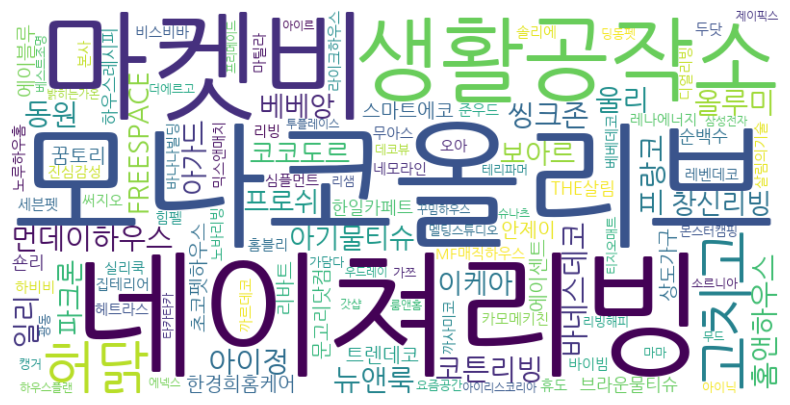

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import os

# CSV 파일이 있는 디렉터리 경로
folder_path = 'C:/Users/JOOYONKJ/Desktop/work/오늘의집 프로젝트/data_100/'

# 디렉터리 내의 모든 CSV 파일을 가져오고 파일명을 정렬
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
csv_files.sort()

# 빈 데이터프레임 생성
merged_data = pd.DataFrame()

# 정렬된 파일들을 순회하면서 데이터를 합침
for csv_file in csv_files:
    filename = os.path.join(folder_path, csv_file)
    
    # 파일이 존재하는지 확인 
    if os.path.exists(filename):
        data = pd.read_csv(filename)
        
        # 데이터를 합침
        merged_data = pd.concat([merged_data, data], ignore_index=True)

# 제품명 데이터 가져오기
brand_names = merged_data['브랜드']

# 단어 또는 키워드로 분리
keywords = brand_names.str.split().explode()

filtered_keywords = keywords[keywords.duplicated(keep=False)]
keyword_counts = filtered_keywords.value_counts()

# 중복된 키워드 빈도수가 5번 이상인 키워드 필터링
filtered_keyword_counts = keyword_counts[keyword_counts >= 5]

# 필터링된 중복 키워드를 하나의 텍스트로 결합
text = ' '.join(filtered_keyword_counts.index)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

# 워드클라우드 이미지를 PIL 이미지로 변환
wordcloud_image = Image.fromarray(wordcloud.to_array())

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 표시 제거
plt.show()


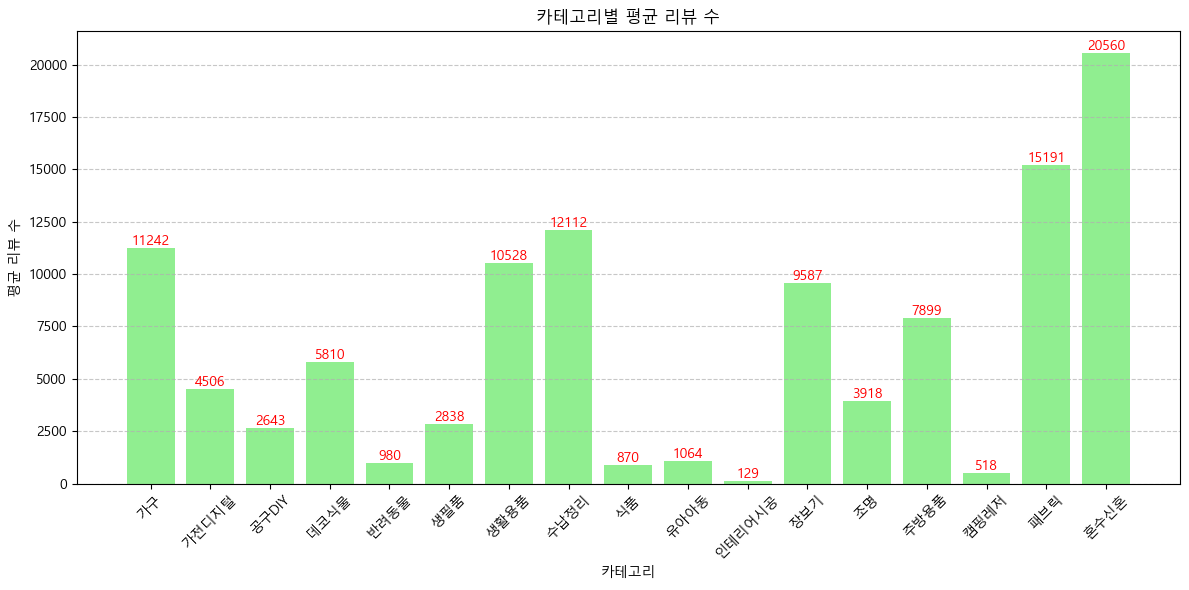

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm  # 폰트 관련 모듈 추가

# 그래프 관련 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 폰트 설정
plt.rcParams['font.size'] = 10  # 글자 크기 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 글자 깨짐 방지

# 폴더 경로 설정
output_folder = 'data_100'

# 빈 리스트 생성
category_names = []
average_review_counts = []

# 폴더 내의 모든 CSV 파일을 순회
for filename in os.listdir(output_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(output_folder, filename)
        
        # CSV 파일을 데이터프레임으로 읽어오기
        data = pd.read_csv(file_path)
        
        # 리뷰수 열 데이터 가져오기
        review_counts = data['리뷰수']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(review_counts):
            review_counts = review_counts.astype(str)
        cleaned_review_counts = review_counts.str.replace(',', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 평균 계산
        average_review_count = cleaned_review_counts.dropna().mean()
        
        # 소수점 이하 제거
        average_review_count = int(average_review_count)
        
        # 파일 이름에서 확장자(.csv) 제거하여 리스트에 추가
        category_names.append(os.path.splitext(filename)[0])
        average_review_counts.append(average_review_count)

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(category_names, average_review_counts, color='lightgreen')
plt.xlabel('카테고리')
plt.ylabel('평균 리뷰 수')
plt.title('카테고리별 평균 리뷰 수')
plt.xticks(rotation=45)  # 카테고리 이름이 길 때, 가로로 표시

# 각 막대 위에 평균 리뷰 수 숫자 표시
for bar, avg in zip(bars, average_review_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, avg, str(avg), ha='center', va='bottom', color='red')

plt.tight_layout()

# y축 범위에 따라 그리드 그리기
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


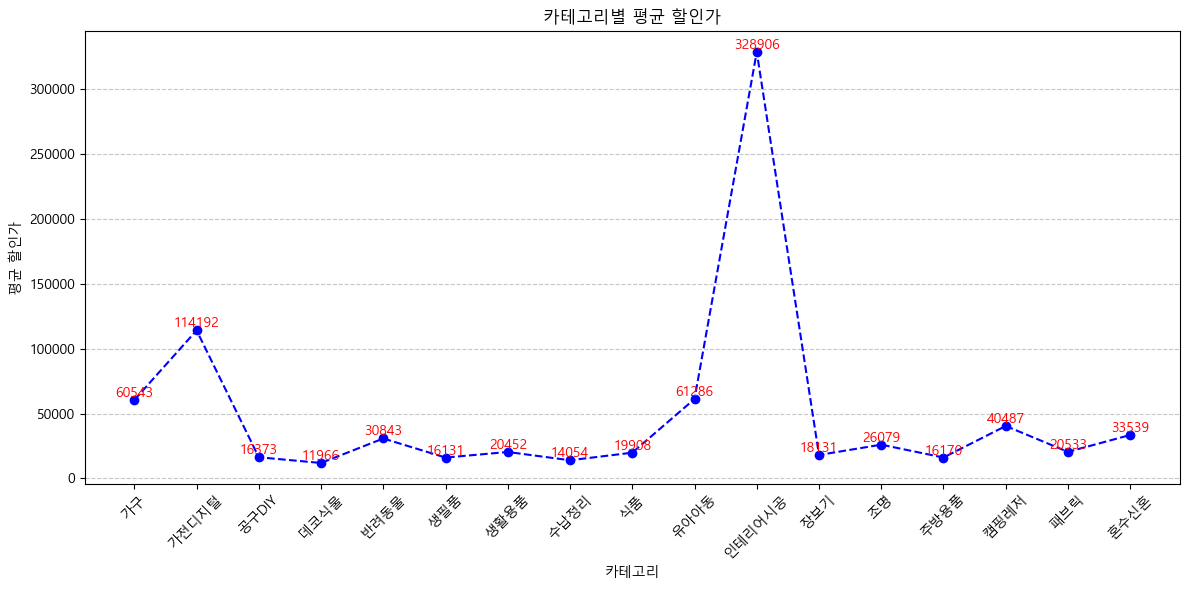

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폴더 경로 설정
output_folder = 'data_100'  

# 빈 리스트 생성
category_names = []
average_discounts = [] 

# 폴더 내의 모든 CSV 파일을 순회
for filename in os.listdir(output_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(output_folder, filename)
        
        # CSV 파일을 데이터프레임으로 읽어오기
        data = pd.read_csv(file_path)
        
        # 할인가 열 데이터 가져오기
        discount_data = data['할인가']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(discount_data):
            discount_data = discount_data.astype(str)
        cleaned_discount_data = discount_data.str.replace(',', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 평균 계산
        average_discount = cleaned_discount_data.dropna().mean()
        
        # 소수점 이하 제거
        average_discount = int(average_discount)
        
        # 파일 이름에서 확장자(.csv) 제거하여 리스트에 추가
        category_names.append(os.path.splitext(filename)[0])
        average_discounts.append(average_discount)

# 그래프 출력
plt.figure(figsize=(12, 6))

# 선 그래프로 변경
plt.plot(category_names, average_discounts, marker='o', linestyle='--', color='blue')  # 선 그래프 설정

plt.xlabel('카테고리')
plt.ylabel('평균 할인가')
plt.title('카테고리별 평균 할인가')
plt.xticks(rotation=45)  # 카테고리 이름이 길 때, 가로로 표시

# 각 점에 평균 할인가 숫자 표시
for category, avg in zip(category_names, average_discounts):
    plt.text(category, avg, str(avg), ha='center', va='bottom', color='red')

# y축 범위에 따라 그리드 그리기
plt.grid(axis='y', linestyle='--', alpha=0.7)    
plt.tight_layout()
plt.show()


C:\Users\JOOYONKJ\AppData\Local\Temp\ipykernel_3672\2010648773.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(category_names, rotation=45)


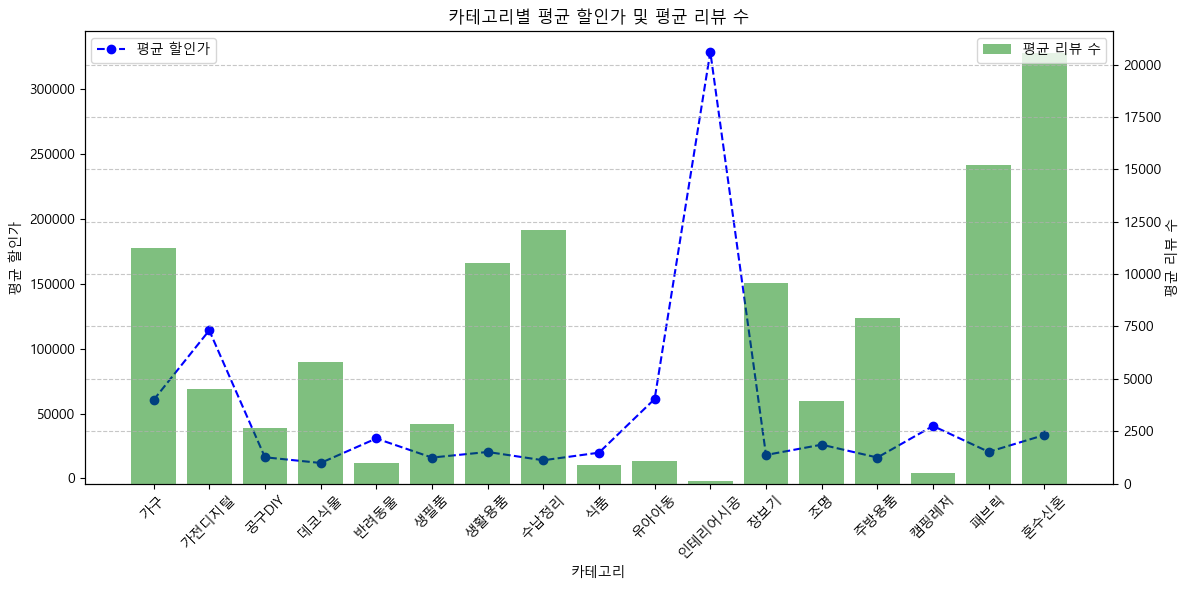

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm  # 폰트 관련 모듈 추가

# 폴더 경로 설정
output_folder = 'data_100'

category_names = []
average_discounts = []  
average_review_counts = [] 

# 폴더 내의 모든 CSV 파일을 순회
for filename in os.listdir(output_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(output_folder, filename)
        
        # CSV 파일을 데이터프레임으로 읽어오기
        data = pd.read_csv(file_path)
        
        # 할인가 열 데이터 가져오기
        discount_data = data['할인가']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(discount_data):
            discount_data = discount_data.astype(str)
        cleaned_discount_data = discount_data.str.replace(',', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 평균 계산
        average_discount = cleaned_discount_data.dropna().mean()
        
        # 소수점 이하 제거
        average_discount = int(average_discount)
        
        # 리뷰수 열 데이터 가져오기
        review_counts = data['리뷰수']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(review_counts):
            review_counts = review_counts.astype(str)
        cleaned_review_counts = review_counts.str.replace(',', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 평균 계산
        average_review_count = cleaned_review_counts.dropna().mean()
        
        # 소수점 이하 제거
        average_review_count = int(average_review_count)
        
        # 파일 이름에서 확장자(.csv) 제거하여 리스트에 추가
        category_names.append(os.path.splitext(filename)[0])
        average_discounts.append(average_discount)
        average_review_counts.append(average_review_count)

# 그래프 출력
fig, ax1 = plt.subplots(figsize=(12, 6))

# 평균 할인가의 점선 그래프
ax1.plot(category_names, average_discounts, marker='o', linestyle='--', color='blue', label='평균 할인가')
ax1.set_xlabel('카테고리')
ax1.set_ylabel('평균 할인가', color='black')
ax1.tick_params(axis='y', labelcolor='blue')

# 평균 리뷰 수의 막대 그래프
ax2 = ax1.twinx()
ax2.bar(category_names, average_review_counts, alpha=0.5, color='green', label='평균 리뷰 수')
ax2.set_ylabel('평균 리뷰 수', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 그래프 레이블 표시
plt.title('카테고리별 평균 할인가 및 평균 리뷰 수')
ax1.set_xticklabels(category_names, rotation=45)

# 범례 표시
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# y축 범위에 따라 그리드 그리기
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


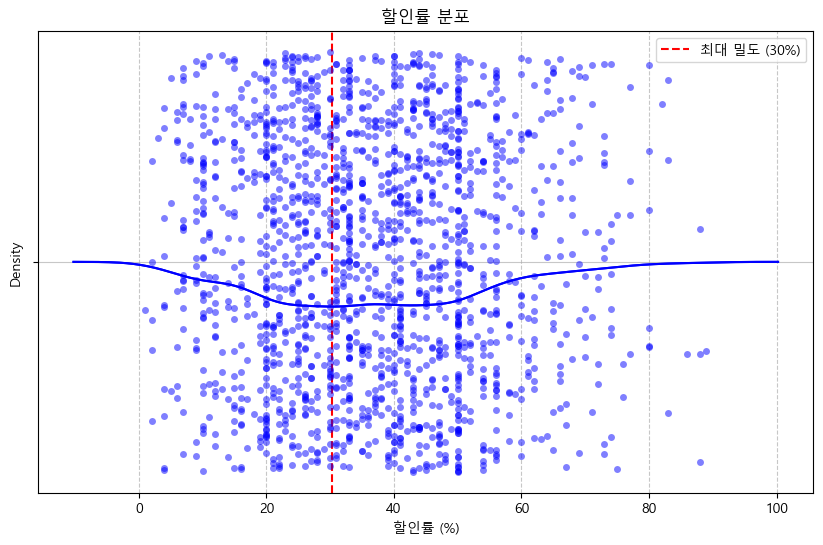

In [33]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 폴더 경로 설정
data_folder = 'data_100'

# 빈 리스트 생성
dis_rate = []

# 폴더 내의 모든 CSV 파일을 순회
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_folder, filename)
        
        # CSV 파일을 데이터프레임으로 읽어오기
        data = pd.read_csv(file_path)
        
        # 할인율 열 데이터 가져오기
        discount_rate = data['할인률']
        
        # 데이터 형식이 문자열이 아닌 경우 문자열로 변환 후 쉼표(,) 제거하여 숫자로 변환
        if not pd.api.types.is_string_dtype(discount_rate):
            discount_rate = discount_rate.astype(str)
        cleaned_discount_rate = discount_rate.str.replace('%', '').apply(pd.to_numeric, errors='coerce')
        
        # NaN(숫자가 아닌 값)을 제외하고 리스트에 추가
        dis_rate.extend(cleaned_discount_rate.dropna())

# Seaborn을 사용하여 할인율 데이터를 점 그래프로 시각화
plt.figure(figsize=(10, 6))
sns.stripplot(x=dis_rate, jitter=True, color='blue', alpha=0.5)
plt.xlabel('할인률 (%)')
plt.title('할인률 분포')

plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 커널 밀도 추정 그래프에서 가장 높은 밀도를 가지는 부분 찾기
max_density_x = sns.kdeplot(dis_rate, color='blue').get_lines()[0].get_data()[0][sns.kdeplot(dis_rate, color='blue').get_lines()[0].get_data()[1].argmax()]

# 빨간색 수직선 그리기
plt.axvline(max_density_x, color='red', linestyle='--', label=f'최대 밀도 ({int(max_density_x)}%)')
plt.legend()
# 그래프 출력
plt.show()


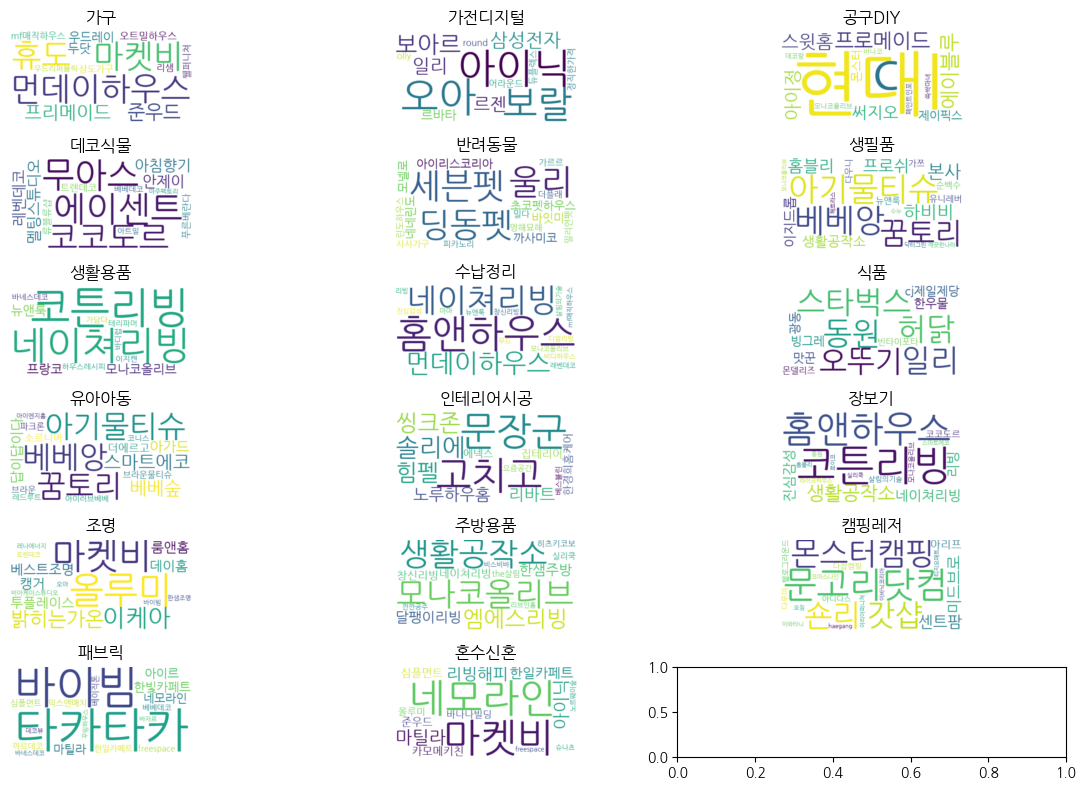

In [35]:
import os
import pandas as pd
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 새로운 캐시 폰트 경로 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 폴더 이름
folder_name = 'data_100'

# 데이터프레임 초기화
data = []

# 모든 CSV 파일 읽어오기
for filename in os.listdir(folder_name):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_name, filename)
        df = pd.read_csv(file_path)
        product_names = ' '.join(df['브랜드']).lower()

        # 단어 토큰화 및 빈도수 계산
        words = word_tokenize(product_names)
        word_freq = FreqDist(words)

        # 2번 이상 반복되는 단어 선택 (원하는 숫자로 수정 가능)
        selected_words = [word for word, freq in word_freq.items() if freq >= 3]

        # 데이터에 추가
        data.append({'Category': filename[:-4], 'Words': selected_words})

# 서브플롯에 워드 클라우드 그리기
num_rows = 6
num_cols = 3  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, category_data in enumerate(data):
    category = category_data['Category']
    words = category_data['Words']

    # 워드 클라우드에 한글 폰트 적용
    wordcloud = WordCloud(width=400, height=200, background_color='white', font_path=font_path).generate(' '.join(words))

    row = i // num_cols
    col = i % num_cols

    # 서브플롯에 워드 클라우드 추가
    if num_rows > 1:
        axes[row, col].imshow(wordcloud, interpolation='bilinear')
        axes[row, col].set_title(category)
        axes[row, col].axis('off')
    else:
        axes[col].imshow(wordcloud, interpolation='bilinear')
        axes[col].set_title(category)
        axes[col].axis('off')

plt.tight_layout()
plt.show()
